Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Selected Features:
['ST_Slope' 'ChestPainType' 'Oldpeak' 'ExerciseAngina' 'MaxHR']

Random Forest Classifier with Selected Features:
Train Accuracy: 0.984399375975039
Test Accuracy: 0.8369565217391305
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       128
           1       0.85      0.84      0.85       148

    accuracy                           0.84       276
   macro avg       0.84      0.84      0.84       276
weighted avg       0.84      0.84      0.84       276

Classification Report for Train Set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       282
           1       0.98      0.99      0.99       359

    accuracy                           0.98       641
   macro avg       0.98      0.98      0

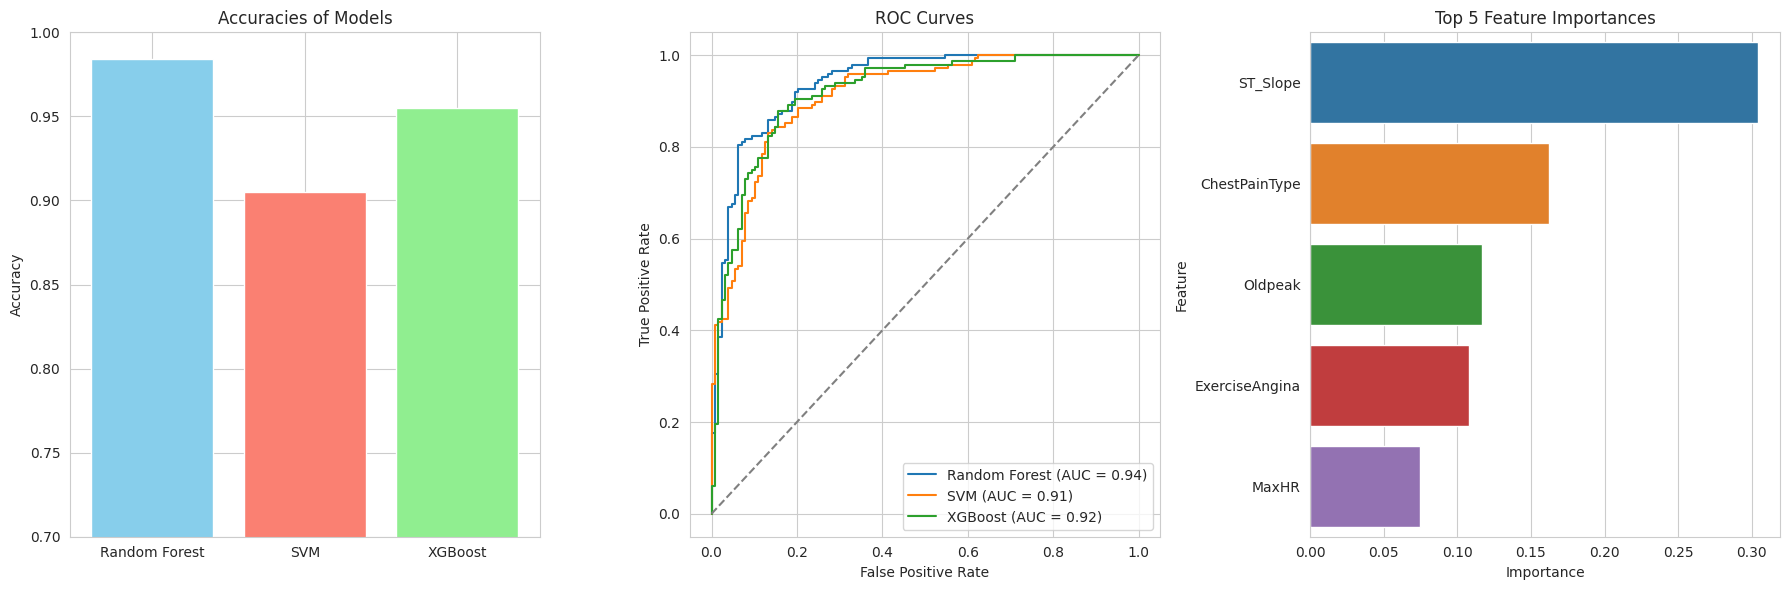

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn import tree

# Read the dataset
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

# Remove records with RestingBP = 0
df = df[df['RestingBP'] > 0]

# Replace 0 values in the 'Cholesterol' column with 244.6
df['Cholesterol'] = df['Cholesterol'].replace(0, 244.6)

# Convert object columns to numeric
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'M' else 0)
df['ExerciseAngina'] = df['ExerciseAngina'].apply(lambda x: 1 if x == 'Y' else 0)

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df['ChestPainType'] = lb.fit_transform(df['ChestPainType'])
df['RestingECG'] = lb.fit_transform(df['RestingECG'])
t = {'Down':0, 'Flat':1, 'Up':2}
df['ST_Slope'] = df['ST_Slope'].map(t)

# Prepare features and target
X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

# Apply Power Transformer to normalize features
pt = PowerTransformer()
X_normalized = pt.fit_transform(X)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=50)

# Random Forest Classifier with hyperparameter tuning
rf_classifier = RandomForestClassifier(class_weight='balanced')

# Define the hyperparameters grid
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5)
grid_search_rf.fit(x_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

# Train Random Forest with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params_rf)
best_rf_classifier.fit(x_train, y_train)

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N features
top_n_features = 5
selected_features = feature_importance_df.head(top_n_features)['Feature'].values

print("Selected Features:")
print(selected_features)


X_selected = X[selected_features]

# Split the data into training and testing sets using only selected features
x_train_selected, x_test_selected, y_train, y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=50)

# Train Random Forest Classifier on selected features
rf_classifier_selected = RandomForestClassifier(class_weight='balanced')

# Train Random Forest Classifier on selected features
rf_classifier_selected.fit(x_train_selected, y_train)

# Evaluate Random Forest Classifier with selected features
y_pred_rf_test_selected = rf_classifier_selected.predict(x_test_selected)
y_pred_rf_train_selected = rf_classifier_selected.predict(x_train_selected)

print("\nRandom Forest Classifier with Selected Features:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_rf_train_selected))
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf_test_selected))
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_rf_test_selected))
print("Classification Report for Train Set:")
print(classification_report(y_train, y_pred_rf_train_selected))

# SVM Classifier with hyperparameter tuning
svm_classifier = SVC(class_weight='balanced')

# Define the hyperparameters grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Perform GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm_classifier, param_grid=param_grid_svm, cv=5)
grid_search_svm.fit(x_train, y_train)

# Get the best parameters
best_params_svm = grid_search_svm.best_params_
print("\nBest Parameters for SVM:", best_params_svm)

# Train SVM with the best parameters
best_svm_classifier = SVC(**best_params_svm, probability=True)
best_svm_classifier.fit(x_train, y_train)

# Evaluate SVM
y_pred_svm_train = best_svm_classifier.predict(x_train)
y_pred_svm_test = best_svm_classifier.predict(x_test)

print("\nSVM Classifier:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_svm_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm_test))
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_svm_test))
print("Classification Report for Train Set:")
print(classification_report(y_train, y_pred_svm_train))

# XGBoost Classifier with hyperparameter tuning
xgb_classifier = XGBClassifier()

# Define the hyperparameters grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid_xgb, cv=5)
grid_search_xgb.fit(x_train, y_train)

# Get the best parameters
best_params_xgb = grid_search_xgb.best_params_
print("\nBest Parameters for XGBoost:", best_params_xgb)

# Train XGBoost with the best parameters
best_xgb_classifier = XGBClassifier(**best_params_xgb)
best_xgb_classifier.fit(x_train, y_train)

# Evaluate XGBoost
y_pred_xgb_train = best_xgb_classifier.predict(x_train)
y_pred_xgb_test = best_xgb_classifier.predict(x_test)

print("\nXGBoost Classifier:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_xgb_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_xgb_test))
print("Classification Report for Train Set:")
print(classification_report(y_train, y_pred_xgb_train))

# Set seaborn style
sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(18, 6))

# Plot train accuracies
plt.subplot(1, 3, 1)
train_accuracies = [accuracy_score(y_train, y_pred_rf_train_selected), accuracy_score(y_train, y_pred_svm_train), accuracy_score(y_train, y_pred_xgb_train)]
classifier_names = ['Random Forest', 'SVM', 'XGBoost']
plt.bar(classifier_names, train_accuracies, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Accuracies of Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)

# Plot ROC curves
plt.subplot(1, 3, 2)
for clf, name in zip([best_rf_classifier, best_svm_classifier, best_xgb_classifier], ['Random Forest', 'SVM', 'XGBoost']):
    probs = clf.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    auc_score = roc_auc_score(y_test, probs[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot feature importances
plt.subplot(1, 3, 3)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n_features))
plt.title('Top 5 Feature Importances')

plt.tight_layout()
plt.show()



